# Local averaging methods

In local averaging methods, the response at a particular point is given by some weighed average of the response values of the training set. Formally, the predictor is given by 

$$f(x) = \sum_{i=1}^n w_i(x) y_i$$

Different design choices of $w_i(x)$ give rise to predictors with different performance.

## k-Nearest neighbors

In k-Nearest neighbors, the response at $x$ is given by the average of the response of the $k$ nearest neighbors of $x$. In other words, 

$$f(x) = \frac{1}{k} \sum_{i=1}^n\mathbb{1}\{x_i\in N_k(x)\}y_i$$

Note that this corresponds to weight of the form

$$ w_i(x) =  \frac{1}{k} \mathbb{1}\{x_i\in N_k(x)\}$$

Which assigns a weight of $1/k$ if $x_i$ is one of the $k$ nearest neighbors of $x$. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [20]:
class kNearestNeighbors:
    
    def __init__(self, X, y, k):
        self.X = X
        self.y = y
        self.k = k
    
    def predict(self, X_test):
        y_pred = []
        for x in X_test:
            distance = np.linalg.norm(self.X - x, axis=1)
            nearest_neighbors_indices = np.argsort(distance)[:self.k]
            k_nearest_values = self.y[nearest_neighbors_indices]
            y_pred.append(np.mean(k_nearest_values))
        return np.array(y_pred)

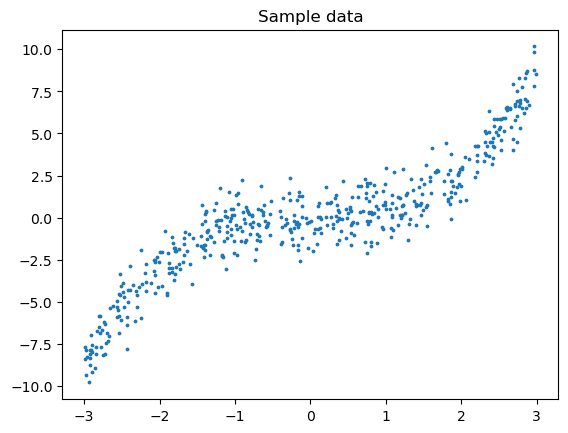

In [21]:
X = np.random.uniform(-3, 3, 500)
y = 0.3 * X ** 3 + 0.2 * X + np.random.randn(500)

plt.scatter(X, y, s=3)
plt.title("Sample data")
plt.show()

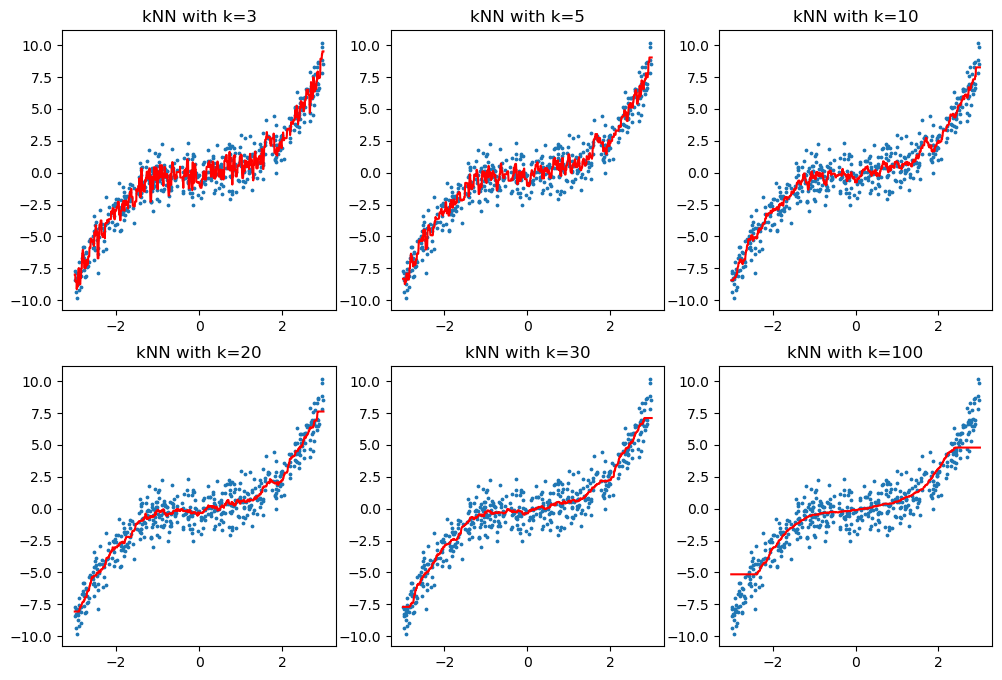

In [39]:
fig, ax = plt.subplots(2, 3, figsize=(12, 8))
ax = ax.flatten()
xx = np.linspace(-3, 3, 1000)
k = [3, 5, 10, 20, 30, 100]
for i in range(6):
    kNN = kNearestNeighbors(X.reshape(X.shape[0], 1), y, k[i])
    y_pred = kNN.predict(xx)
    ax[i].plot(xx, y_pred, c="r")
    ax[i].scatter(X, y, s=3)
    ax[i].set_title(f"kNN with k={k[i]}")
plt.show()

## Partitioning estimators

The partitioning estimators works in a similar fashion compared with $k$ nearest neighbors. Let $A_{1}, A_{2},...A_{n}$ be a paritition of $\mathbb{R}^d$. And let $A(x)$ be the partition that contains $x$. The partition estimate estimates a new value by 

$$f(x) = \frac{\sum_{i=1}^n y_i\mathbb{1}\{x_i\in A(x)\}}{\sum_{i=1}^n \mathbb{1}\{x_i\in A(x)\}}$$

In other words, it takes the average response value in $A(x)$. The weight becomes

$$w_i(x) = \frac{\mathbb{1}\{x_i\in A(x)\}}{\sum_{i=1}^n \mathbb{1}\{x_i\in A(x)\}}$$

In [61]:
class partitionEstimator:
    
    def __init__(self, X, y, partitions):
        self.X = X
        self.y = y
        self.partitions = partitions
        
    def predict(self, X_test):
        y_pred = []
        for x in X_test:
            for l, u in zip(partitions, partitions[1:]):
                if l <= x <= u:
                    y_pred.append(y[(l <= X) & (X < u)].mean())
                    break
        return np.array(y_pred)

/var/folders/51/mms6ntkn5vg1pnv9_9003dwm0000gn/T/ipykernel_53427/826368697.py:13: RuntimeWarning: Mean of empty slice.
  y_pred.append(y[(l <= X) & (X < u)].mean())


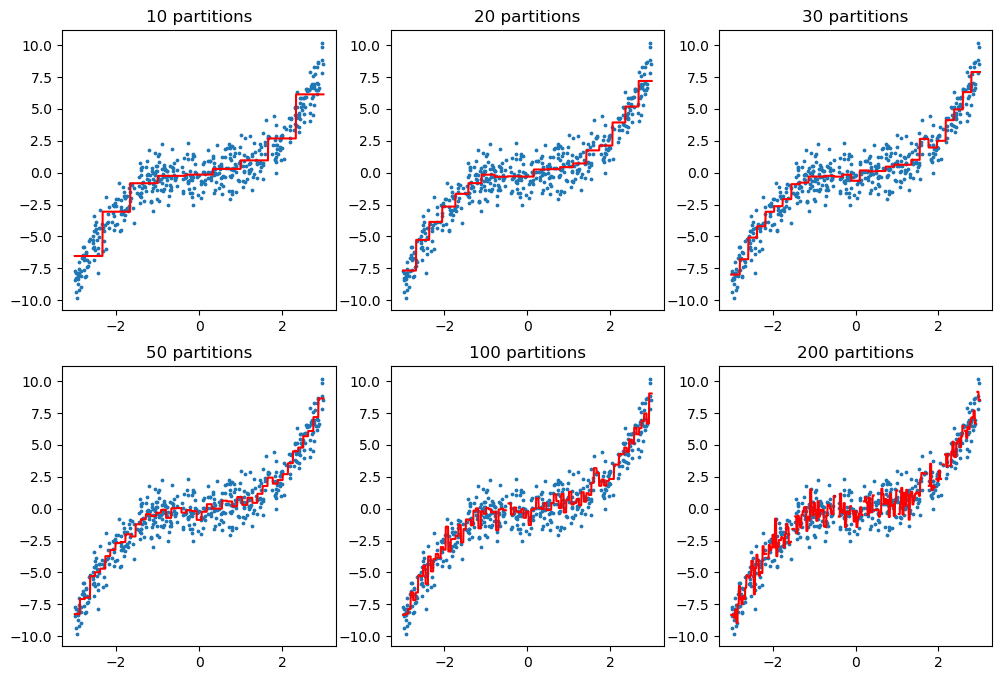

In [67]:
fig, ax = plt.subplots(2, 3, figsize=(12, 8))
ax = ax.flatten()
xx = np.linspace(-3, 3, 1000)
n_partitions = [10, 20, 30, 50, 100, 200]
for i in range(6):
    partitions = np.linspace(-3, 3, n_partitions[i])
    model = partitionEstimator(X, y, partitions)
    y_pred = model.predict(xx)
    ax[i].plot(xx, y_pred, c="r")
    ax[i].scatter(X, y, s=3)
    ax[i].set_title(f"{n_partitions[i]} partitions")
plt.show()

## Kernel regression

Kernel regression, also known as Nadaraya-Watson estimator, is a generalization of k-nearest neighbors and partitioning estimators. It defines the weights as 

$$w_i(x) = \frac{k(x, x_i)}{\sum_{i=1}^n k(x, x_i)}$$

Where $k:\mathcal{X}\times \mathcal{X}\rightarrow \mathbb{R}^+$ denote any kernel function. If $k(x, x_i)=0$ for all $i$, then by convention, we define $w_i(x)=1/n$. In most cases when $\mathcal{X}=\mathbb{R}^d$, we typically define

$$k(x, x') = \frac{1}{h^d}q\bigg(\frac{x-x'}{h}\bigg)$$

Where $q:\mathbb{R}^d\rightarrow \mathbb{R}$ is any function that has large values around the center. Two typical choice of $q$ includes box kernels and Gaussian kernel. In both of these cases, we see that the kernel regression model, when predicting $x$, considers the response values with closer distance with higher priority. 

In [68]:
class kernelRegression:
    
    def __init__(self, X, y, kernel):
        self.X = X
        self.y = y
        self.kernel = kernel
        
    def predict(self, X_test):
        y_pred = []
        for x in X_test:
            k = np.array([self.kernel(x, X[i]) for i in range(len(X))])
            w = k / np.sum(k)
            y_pred.append(np.dot(w, y))
        return np.array(y_pred)

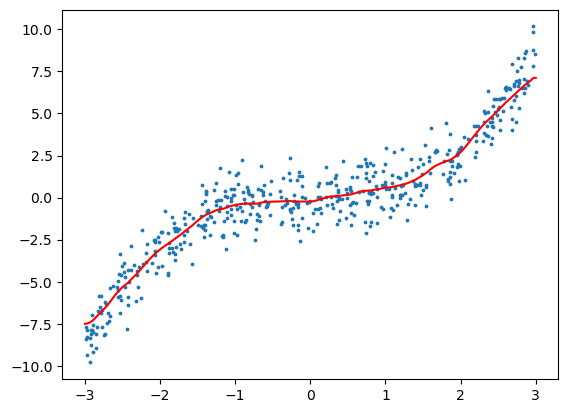

In [73]:
kernel_func = lambda x, z: np.exp(-np.linalg.norm(x - z) / (2 * 0.1)) / 0.1
kernel = kernelRegression(X, y, kernel_func)
y_pred = kernel.predict(xx)

plt.plot(xx, y_pred, c="r")
plt.scatter(X, y, s=3)
plt.show()

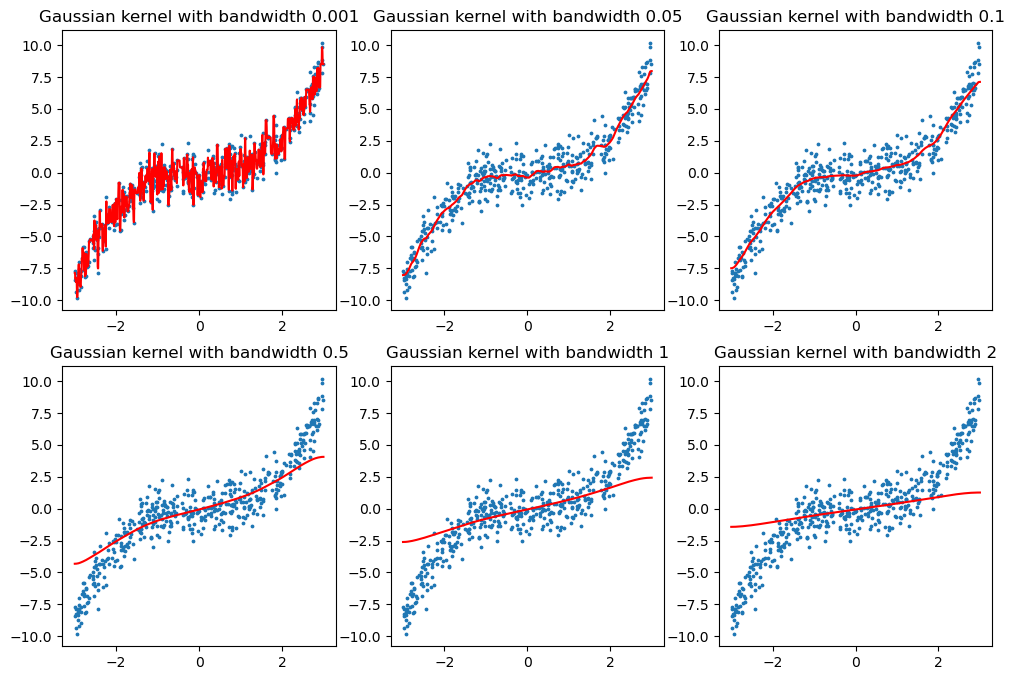

In [76]:
fig, ax = plt.subplots(2, 3, figsize=(12, 8))
ax = ax.flatten()
xx = np.linspace(-3, 3, 1000)
h = [1e-3, 5e-2, 0.1, 0.5, 1, 2]
for i in range(6):
    kernel_func = lambda x, z: np.exp(-np.linalg.norm(x - z) / (2 * h[i])) / h[i]
    kernel = kernelRegression(X, y, kernel_func)
    y_pred = kernel.predict(xx)
    ax[i].plot(xx, y_pred, c="r")
    ax[i].scatter(X, y, s=3)
    ax[i].set_title(f"Gaussian kernel with bandwidth {h[i]}")
plt.show()

/var/folders/51/mms6ntkn5vg1pnv9_9003dwm0000gn/T/ipykernel_53427/4023436712.py:12: RuntimeWarning: invalid value encountered in divide
  w = k / np.sum(k)


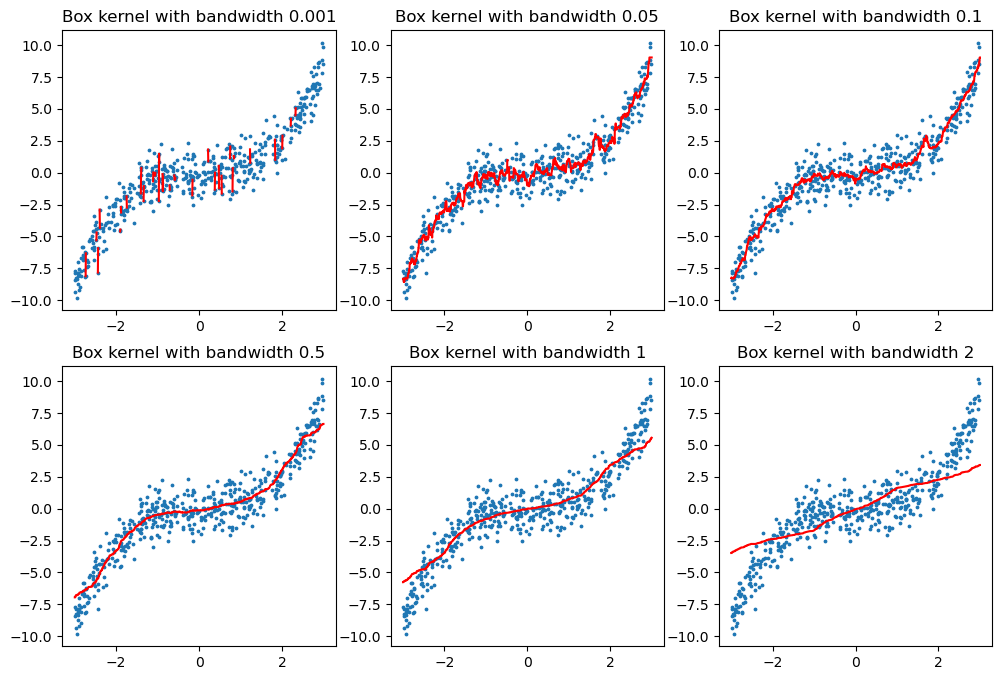

In [79]:
fig, ax = plt.subplots(2, 3, figsize=(12, 8))
ax = ax.flatten()
xx = np.linspace(-3, 3, 1000)
h = [1e-3, 5e-2, 0.1, 0.5, 1, 2]
for i in range(6):
    kernel_func = lambda x, z: 1 / h[i] if np.linalg.norm(x - z) <= h[i] else 0
    kernel = kernelRegression(X, y, kernel_func)
    y_pred = kernel.predict(xx)
    ax[i].plot(xx, y_pred, c="r")
    ax[i].scatter(X, y, s=3)
    ax[i].set_title(f"Box kernel with bandwidth {h[i]}")
plt.show()